This is a showcase of what the diffusion package allows to do.

Let's start with all the basic imports, just to get them out of the way.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from diffusion import simulator as sim
from diffusion import plots, analyse
import statsmodels.api as sm

Let's start by defining a simulating the diffusion of a single trajectory and visualizing it. Default diffusivity coefficient is 30 μm/s².

,frame,particle,x,y
0,1,0,0.000000,0.000000
1,2,0,-0.158141,-0.116914
2,3,0,-0.174696,0.121664
3,4,0,0.185753,0.243435
4,5,0,-0.065355,0.485022


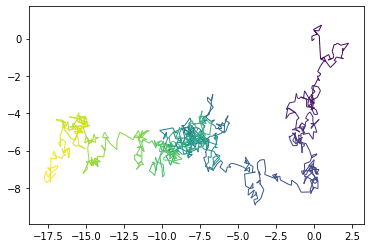

In [3]:
length = 1000
startingPosition = (0,0)
traj = sim.singleTraj(length, startingPosition)

plots.plotSingleTraj(traj)
traj.head()

The way diffusion works, at each frame we draw (dx, dy), the displacements along the two axis. It comes from the function displace(), and takes in as arguments the diffusivity, fps and mpp, and draws the random number from a normal distribution with mean 0 and standard deviation sqrt(2 * diffusivity * (1/fps)).

I then multiply that by the mpp, but I'm not sure if that is correct (also because diffusivity * Tinterval is not homogeneous to a distance?). This mulitplication I think serves as the scaling factor. But so far, everything has been written with the assumption that the spacial unit is micrometers, and we are at 1000fps, so 1 miliseconds per loop.

Moving on, we can output a few things on this trajectory, starting with the histogram of displacements.

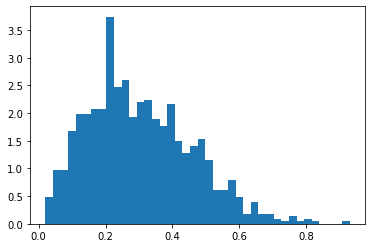

(0.302993327072754, 0.15471156075108944)


In [4]:
plots.displacementHistogram(traj, bins = 40)

It also prints mean and standard deviation of the displacement, but careful as this comes from fitting a gaussian through the data, which a priori is just wrong. This is a pending attempt to output something resembling what is shown in Mazza, 2012 or Loffreda, 2017.

Another thing we can do with this trajectory is calculate MSD. This is made with the differences between (r(t+Tau) - r(t))<exp>2</exp>). The function msd() returns a pandas DataFrame, which allows us to visualize it pretty quickly.

,msds,tau,msds_std,observations
0,0.115741,1,0.112063,999.0
1,0.232847,2,0.229436,998.0
2,0.350136,3,0.348235,997.0
3,0.469104,4,0.448614,996.0
4,0.589127,5,0.561334,995.0


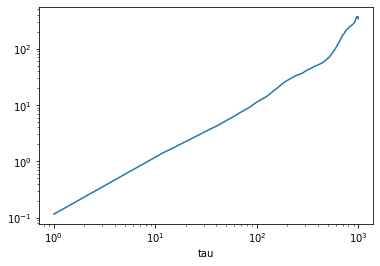

In [5]:
msds = analyse.msd(traj)
msds.plot(x='tau', y='msds', logx=True, logy=True, legend=False)
msds.head()

Interestingly, at very long time lines, I often find that it behaves weirdly, which sort of make sense because we start to have a lot less observations. Still, it's annoying because it sort of messes up the coefficient D calculation. One way to do it is to do a linear fit between tau and the MSDs as follows :

In [6]:
X = msds['tau']
X = sm.add_constant(X) #let's us add an constant parameter, the intercept, for the linear reg
model = sm.OLS(msds['msds'], X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   msds   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     7624.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:23:51   Log-Likelihood:                -5010.4
No. Observations:                 999   AIC:                         1.002e+04
Df Residuals:                     997   BIC:                         1.003e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.4607      2.312    -24.856      0.000     -61.997     -52.924
tau            0.3497      0.004     87.316      0.000       0.342       0.358
==============================================================================
Omnibus:                       57.047   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.100
Skew:                           0.269   Prob(JB):                     1.76e-07
Kurtosis:                       2.323   Cond. No.                     1.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Not only is the R² really poor, but the coefficient for Tau is 0.0566. This is 4D, where D is in s<exp>-2</exp>, whereas the time interval is in miliseconds, so to go from the coefficient to D, you need to divide by 4 x 10<exp>-3</exp>. which gives us 14.15, pretty far off from the real value. Another way to estimate D is

In [7]:
msd = msds['msds'].values
tau = msds['tau'].values
Ds = msd / tau
Ds = Ds / 0.004
D_calcul = np.mean(Ds)
print(D_calcul)

47.73447637398148


Which is already way closer to the truth. I am not sure what happens, but my guess is that the linear fit gives to much importance to the very long lag times. We could try to consider only the first time lags.

In [8]:
first20 = msds[:20]
X = first20['tau']
X = sm.add_constant(X) #let's us add an constant parameter, the intercept, for the linear reg
model = sm.OLS(first20['msds'], X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   msds   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.671e+04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.59e-28
Time:                        12:23:51   Log-Likelihood:                 48.438
No. Observations:                  20   AIC:                            -92.88
Df Residuals:                      18   BIC:                            -90.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.011      2.700      0.015       0.006       0.050
tau            0.1135      0.001    129.266      0.000       0.112       0.115
==============================================================================
Omnibus:                        2.121   Durbin-Watson:                   0.127
Prob(Omnibus):                  0.346   Jarque-Bera (JB):                1.071
Skew:                           0.092   Prob(JB):                        0.585
Kurtosis:                       1.881   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a coefficient of 0.113, we arrive at D = 28.25, way closer. All in all, I'm not sure what's the best method to go around calculating D, with the linear fit being very sensible to weird values, and also I don't think it works for anomalous diffusions.

# Constrained diffusion, Traps and Binding

Alright, so far so good but pretty limited. To make this a bit more interesting, let's add a region in which the particle is diffusing and cannot escape. The simulator allows us to do that easily.

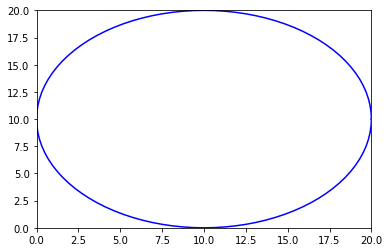

In [9]:
radius = 10
position = (10,10)
nbOfPoints = 100
cell = sim.createCircle(radius, position, nbOfPoints)

sim.drawGeometry(cell)

We now have an area, a "cell", from which the particle cannot escape. Let's watch it in action.

(0, 20)

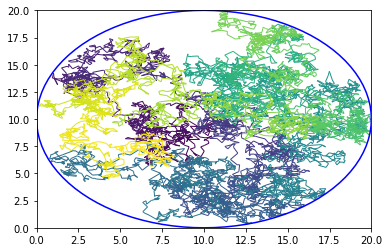

In [10]:
traj = sim.singleTraj(10000, (10,10), ROI = cell)
sim.drawGeometry(cell)
plots.plotSingleTraj(traj)
axes = plt.gca()
axes.set_xlim(0,20)
axes.set_ylim(0,20)

The boundary condition is pretty simple : shapely, the module I use for the geometry, allows to call, for any defined polygon, the function contains() returning True if a given point is inside the polygon. To keep the particle inside, what I do is, after having drawn displacement (dx, dy), I chek if (X+dx, Y+dy) is inside the region of interest :
    - if yes, then add the new position is X+dx, Y+dy
    -if no, then the new positoin is X-dx, Y-dy
    
It's pretty bare bones, and only works if the ROI has a typical size larger than the typical displacement. It does the trick for now, but poses problems for trapping zones, for exemple, which are typically smaller. We can already compare the effect this has on the MSD.

,msds,tau,msds_std,observations
0,0.121640,1,0.123824,9999.0
1,0.243088,2,0.244278,9998.0
2,0.360461,3,0.358884,9997.0
3,0.477986,4,0.475162,9996.0
4,0.596324,5,0.596614,9995.0


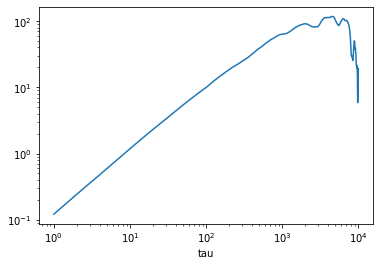

In [13]:
msds = analyse.msd(traj)
msds.plot(x='tau', y='msds', logx=True, logy=True, legend=False)
msds.head()

Where we do see sort of the plateau that we are supposed to see.

We can also define trapping zones.

(0, 20)

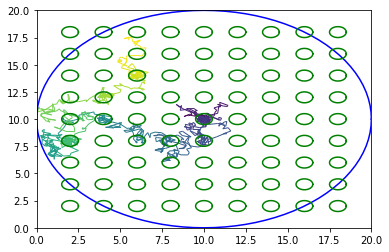

In [15]:
trapList = []
#this reads i in an array starting at 2, ending at 19, with a increment of 2
for i in range(2,19,2):
    for j in range(2,19,2):
        trapList.append(sim.createCircle(0.5, (i,j), 50))

traj = sim.singleTraj(1000, (10,10), ROI = cell, trapList=trapList)
sim.drawGeometry(cell, trapList=trapList)
plots.plotSingleTraj(traj)
axes = plt.gca()
axes.set_xlim(0,20)
axes.set_ylim(0,20)

And then we can easily output the kind of plot shown in Hansen, 2020.

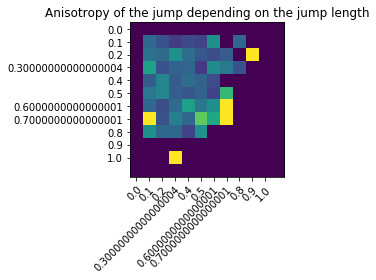

In [16]:
minDisplacement = 0
maxDisplacement = 1
plots.HansenHeatMap(traj, minDisplacement, maxDisplacement)

Except it doesn't *really* look like the results of the paper... 

The few yellow dots don't really mean those are really anisotropic though. It only really means for this combination of displacement length, there was only one jump, that happened to be anisotropic. For each couple of (lengthOfJump(frame), lengthOfJump(next frame)), I count how many were < 30° or > 150°, how many total, and divide the two. So all it takes to have a total anisotropy of 1 is to have a single couple of jump with a specific length, and that jump being anisotropic.

I should maybe divide by the number of jumps total, regardless of their sizes.

Simulation wise, the traps above are 1 micrometer total in diameter, when the ones Hansen reports to produce his anisotropic behavior are 200 nm. But then we get into the problem mentioned above : typical displacement is 200 nanometers as well...

But I can also do binding sites, like described in https://doi.org/10.1016/j.bpj.2017.12.037 , with a capture radius and an escape radius.

(0, 20)

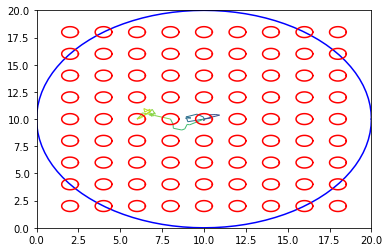

In [17]:
siteList = []
#this reads i in an array starting at 5, ending at 16, with a increment of 5
for i in range(2,19,2):
    for j in range(2,19,2):
        siteList.append(sim.createCircle(0.5, (i,j), 50))

traj = sim.singleTraj(1000, (10,10), ROI = cell, bindingSiteList=siteList)
sim.drawGeometry(cell, bindingSiteList=siteList)
plots.plotSingleTraj(traj)
axes = plt.gca()
axes.set_xlim(0,20)
axes.set_ylim(0,20)

With the default strength of binding hardcoded at 0.99, we see that the particle spends most of its time bound. We can output the anisotropy heatmap still.

/home/tom/Documents/Scientifique/Thèse/code/diffusion/diffusion/utils.py:71: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


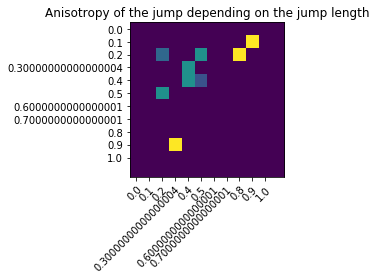

In [18]:
plots.HansenHeatMap(traj, minDisplacement, maxDisplacement)

I'm starting to realize I should really output the number of observations for each cell in the array, because it's really hard to conclude anything.

And of course we can combine binding sites and traps, although I realized this weekend, a binding site *inside* a trap will not work, which is a major design flaw.

(0, 20)

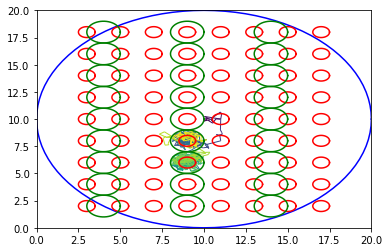

In [20]:
siteList = []

for i in range(3,19,2):
    for j in range(2,19,2):
        siteList.append(sim.createCircle(0.5, (i,j), 50))

trapList = []

for i in range(4,17,5):
    for j in range(2,19,2):
        trapList.append(sim.createCircle(1, (i,j), 50))

traj = sim.singleTraj(1000, (10,10), ROI = cell, bindingSiteList=siteList, trapList = trapList)
sim.drawGeometry(cell, bindingSiteList=siteList, trapList = trapList)
plots.plotSingleTraj(traj)
axes = plt.gca()
axes.set_xlim(0,20)
axes.set_ylim(0,20)

And of course, this all works for the simulation of a group of particle as well !

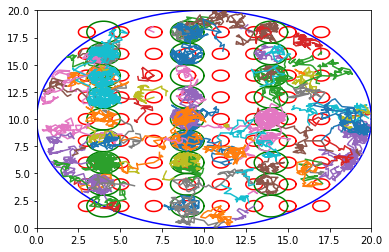

In [22]:
traj = sim.trajectories(100, meanLength = 100, ROI = cell, bindingSiteList = siteList, trapList = trapList)
sim.drawGeometry(cell, bindingSiteList = siteList, trapList=trapList)
plots.plotTraj(traj)

With a data format that looks as follows

In [23]:
traj.head()

,frame,particle,x,y
0,1,0,9.694315,2.475725
1,2,0,9.079887,2.555297
2,3,0,9.204644,2.498963
3,4,0,9.446780,2.520493
4,5,0,9.560982,2.496106
